In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import qutip
import numpy as np
import qutip
import scqubits
from scipy.optimize import minimize
from IPython.display import clear_output
import pickle
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

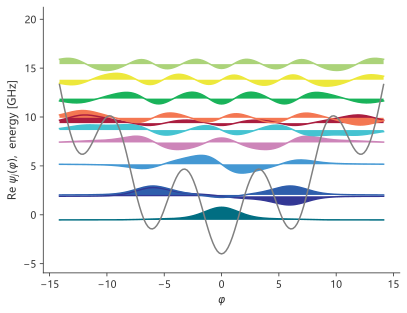

In [2]:
EJ = 4
EC = EJ/2
EL = EJ/30

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=13)

e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(10)]

qbt.fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10])

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 63

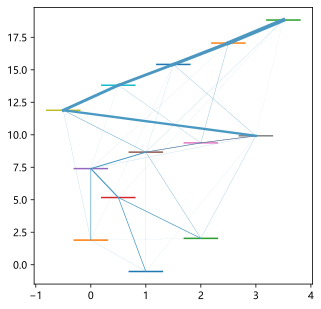

In [3]:
def visualize_c_ops(c_ops,evals):
    level_to_x = {
        0:1,
        1:0,
        2:2,
        3:0.5,
        4:0,
        5:1,
        6:2,
        7:3,
        8:-0.5,
        9:0.5,
        10:1.5,
        11:2.5,
        12:3.5,
    }
    def plot_levels(ax):
        for ql,eval in enumerate(evals):
            eval_with_2pi = eval
            x = level_to_x[ql]
            length = 0.3
            ax.plot([x-length,x+length], [eval_with_2pi,eval_with_2pi])
    def plot_thermalization(ax):
        max_element = np.max(np.abs(np.square((c_ops.full()))))
        max_lw = 4
        lw_scaling_ratio = max_lw/max_element
        decay_color = '#4999c3'
        heating_color = '#d5373d'
        for i in range(len(evals)):
            for j in range(len(evals)):
                if i == j:
                    continue
                else:
                    i_y = evals[i]
                    j_y = evals[j]
                    i_x = level_to_x[i]
                    j_x = level_to_x[j]
                    ax.plot([i_x,j_x], [i_y,j_y], color = decay_color if i < j else heating_color, lw =lw_scaling_ratio* np.abs(np.square((c_ops[i,j])))  )
    fig, ax = plt.subplots(1,1,figsize = (5,5))
    plot_levels(ax)
    plot_thermalization(ax)
    return fig
temp_in_mK = 20
loss_tangent_ref = 1e-5
one_over_f_flux_noise_amplitude = 1e-6
c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
evals = qbt.fluxonium.eigenvals(evals_count=qbt.truncated_dim)

fig  = visualize_c_ops(c_ops,evals)

In [4]:
def objective(x,detuning,t_duration):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]

    detuning1 = detuning
    detuning2 = detuning
    tlist = np.linspace(0,t_duration,t_duration*2)

    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning1,
            detuning2 = detuning2,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = 0,
            amp2_correction_scaling_factor = 0,
        ),
        # c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(f"x:{x}, {detuning},{t_duration}")
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()

    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

x:[2.50888714 2.11321488], 0.5,50


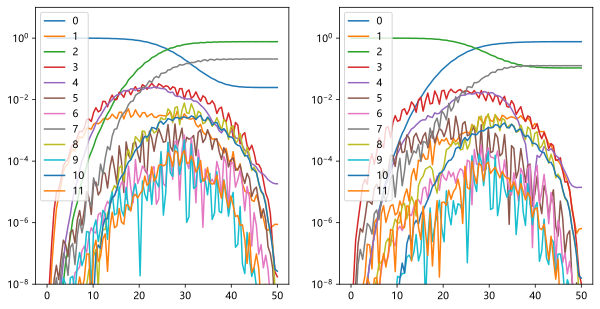

(0.23444590485982497, 0.23447623821216546)


In [58]:
from functools import partial
import pickle

results_dict = {}
for detuning, t_duration, amp_guess in [
                                        (0.1,200,2.3),
                                        (0.2,200,3),
                                        (0.3,200,4),
                                        (0.4,200,4.9),
                                        (0.5,200,5),
                                            
                                        (0.1,150,2),
                                        (0.2,150,2.8),
                                        (0.3,150,3.3),
                                        (0.4,150,4.2),
                                        (0.5,150,4.2),
                                        


                                        (0.1,100,1.7),
                                        (0.2,100,2.3),
                                        (0.3,100,2.6),
                                        (0.4,100,3.8),
                                        (0.5,100,3.6),
    
                                        (0.1,50,1),
                                        (0.2,50,1.7),
                                        (0.3,50,2.1),
                                        (0.4,50,3.3),
                                        (0.5,50,2.2),
                                        ]:
        new_obj = partial(objective, detuning=detuning,t_duration=t_duration)
        result = minimize(new_obj, [amp_guess,amp_guess], method='Nelder-Mead')
        results_dict[(detuning, t_duration)] = result.x
        with open('results_backup.pkl', 'wb') as f:
            pickle.dump(results_dict, f)

In [5]:
with open('results_backup.pkl', 'rb') as f:
    results_dict =   pickle.load( f)

In [6]:
results_dict

{(0.1, 200): array([2.40991117, 2.37426949]),
 (0.2, 200): array([3.40516261, 3.30174762]),
 (0.3, 200): array([4.22135296, 3.99838937]),
 (0.4, 200): array([5.11278619, 4.5596007 ]),
 (0.5, 200): array([5.26335174, 4.92083622]),
 (0.1, 150): array([2.10570469, 2.07351176]),
 (0.2, 150): array([2.96812237, 2.87418743]),
 (0.3, 150): array([3.68381621, 3.47747979]),
 (0.4, 150): array([4.52517208, 3.96810817]),
 (0.5, 150): array([4.51511494, 4.26196686]),
 (0.1, 100): array([1.74901512, 1.72051756]),
 (0.2, 100): array([2.45468004, 2.37068985]),
 (0.3, 100): array([3.05489974, 2.86363554]),
 (0.4, 100): array([3.88609008, 3.27308206]),
 (0.5, 100): array([3.65729768, 3.3436268 ]),
 (0.1, 50): array([1.29623637, 1.27069183]),
 (0.2, 50): array([1.80265254, 1.72589766]),
 (0.3, 50): array([2.26939041, 2.07664036]),
 (0.4, 50): array([3.80418958, 2.37612024]),
 (0.5, 50): array([2.50884953, 2.1132441 ])}

In [7]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 0)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

temp_in_mK = 20
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        Q_cap,
                        one_over_f_flux_noise_amplitude) + qbt.get_Tphi_c_ops(one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]


def truncate_to_computational(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]


states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)
    
def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)

def get_e_pop(state):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,1)), state)
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)

def get_leakage_trace(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return 1-dm.tr()

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 63

In [8]:
detuning_arr = np.array([0.1,0.2,0.3,0.4,0.5])
t_duration_arr = np.array([50,100,150,200])
fidelity_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
leak_to_e_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
additional_leakage_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))

for i,detuning in enumerate(detuning_arr):
    for j, t_duration in enumerate(t_duration_arr):
        amp1, amp2  = results_dict[(detuning, t_duration)]
        tlist = np.linspace(0,t_duration,10*t_duration)

        amp1_scaling_factor = amp1
        amp2_scaling_factor = amp2
        detuning1 = detuning
        detuning2 = detuning

        results  = qbt.run_qutip_mesolve_parrallel(
            initial_states = initial_states,
            tlist = tlist,
            drive_terms = qbt.get_Raman_DRAG_drive_terms(
                i = 0,
                j = 3,
                k = 2,
                detuning1=detuning1,
                detuning2 = detuning2,
                t_duration=t_duration,
                shape='sin^2',
                amp_scaling_factor = 1,
                amp1_scaling_factor = amp1_scaling_factor,
                amp2_scaling_factor = amp2_scaling_factor,
                amp1_correction_scaling_factor = 0,
                amp2_correction_scaling_factor = 0,
            ),
            c_ops = c_ops,
            e_ops = e_ops
        )
        dms = [truncate_to_computational(result.states[-1], 0,2) for result in results]
        def objective_function(phase):
            return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
        opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
        fidelity_arr[i,j] = opt_result.fun

        leakage_to_list = []
        for l in range(len(e_ops)):
            leakage_to_list.append( [get_e_pop_j(result.states[-1], l) for result in results])

        leak_to_e_arr[i,j] = np.mean(leakage_to_list[1])
        additional_leakage_arr[i,j]= np.sum(np.abs(np.array(leakage_to_list)))/len(results)- np.mean(leakage_to_list[1]) - np.mean(leakage_to_list[0]) - np.mean(leakage_to_list[2])
        

 Total run time:   1.26s*] Elapsed 1.26s / Remaining 00:00:00:00 [*********89%********   ] Elapsed 1.30s / Remaining 00:00:00:00 [*********70%****       ] Elapsed 1.07s / Remaining 00:00:00:00
 Total run time:   1.39s ] Elapsed 1.40s / Remaining 00:00:00:00 [********100%***********] Elapsed 1.39s / Remaining 00:00:00:00
 Total run time:   1.47s*] Elapsed 1.47s / Remaining 00:00:00:00 [*********74%*****      ] Elapsed 1.38s / Remaining 00:00:00:00
 Total run time:   1.48s*] Elapsed 1.48s / Remaining 00:00:00:00
 Total run time:   1.50s ] Elapsed 1.46s / Remaining 00:00:00:00
 Total run time:   1.71s*] Elapsed 1.71s / Remaining 00:00:00:00
 Total run time:   2.45s*] Elapsed 2.45s / Remaining 00:00:00:00 [*********78%******     ] Elapsed 2.43s / Remaining 00:00:00:00[*********76%*****      ] Elapsed 2.33s / Remaining 00:00:00:001
 Total run time:   2.92s*] Elapsed 2.92s / Remaining 00:00:00:00[*********98%***********] Elapsed 2.89s / Remaining 00:00:00:000
  Total run time:   2.95s[******

In [9]:
fidelity_arr

array([[2.04997500e-04, 2.43694506e-04, 2.38171730e-04, 2.47677313e-04],
       [1.18406630e-04, 1.23732268e-04, 1.31290867e-04, 1.32692681e-04],
       [8.29630197e-05, 8.58828502e-05, 9.53709864e-05, 7.66960086e-05],
       [7.87347333e-04, 6.86575462e-05, 6.59024389e-05, 6.40199737e-05],
       [2.69555496e-02, 3.11542519e-03, 8.32306488e-05, 6.09989300e-05]])

In [10]:
leak_to_e_arr

array([[0.0003792 , 0.00079304, 0.00120873, 0.00162417],
       [0.00023258, 0.00049205, 0.00077662, 0.00118884],
       [0.00042448, 0.00082956, 0.00124181, 0.00165698],
       [0.00084951, 0.00068592, 0.00083095, 0.0010181 ],
       [0.00044926, 0.00085527, 0.00128433, 0.00169747]])

In [11]:
additional_leakage_arr

array([[9.99541321e-05, 1.22426094e-04, 1.70241092e-04, 1.54595100e-04],
       [2.18816022e-04, 4.01695356e-04, 5.21534502e-04, 5.20713251e-04],
       [1.95765562e-04, 7.32018805e-05, 5.08515674e-05, 7.38309306e-05],
       [3.75234938e-03, 4.86099250e-04, 6.22180029e-04, 8.00848929e-04],
       [1.68102595e-01, 4.16415253e-02, 1.86861954e-03, 3.32725434e-04]])

In [16]:
import pickle

# Store the results to a pickle file
with open('results_data.pkl', 'wb') as f:
    pickle.dump({
        'fidelity_arr': fidelity_arr,
        'leak_to_e_arr': leak_to_e_arr,
        'additional_leakage_arr': additional_leakage_arr
    }, f)

In [ ]:
import pickle

# Load the results from the pickle file
with open('results_data.pkl', 'rb') as f:
    data = pickle.load(f)

fidelity_arr = data['fidelity_arr']
leak_to_e_arr = data['leak_to_e_arr']
additional_leakage_arr = data['additional_leakage_arr']

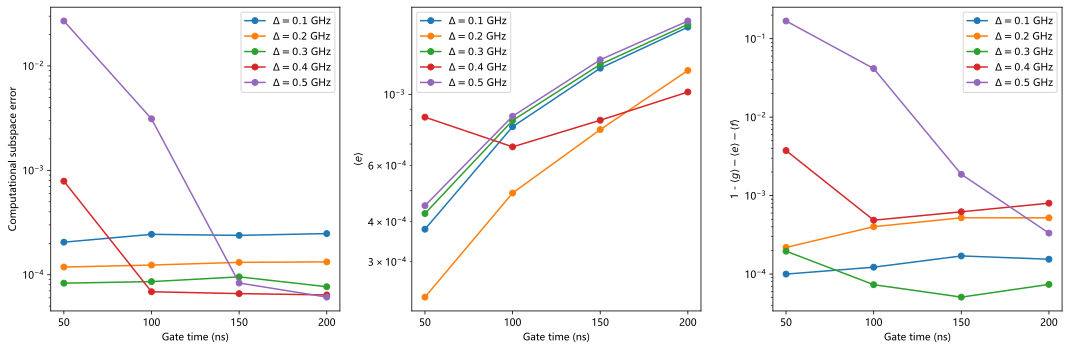

In [12]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Plot the first set of data (Computational subspace error)
for i, detuning in enumerate(detuning_arr):
    axs[0].plot(t_duration_arr, fidelity_arr[i], label=rf"$\Delta={detuning}$ GHz", marker='o')
axs[0].set_yscale('log')
axs[0].set_xticks([50, 100, 150, 200])
axs[0].set_xlabel("Gate time (ns)")
axs[0].set_ylabel("Computational subspace error")
axs[0].legend()

# Plot the second set of data (Leakage to e state)
for i, detuning in enumerate(detuning_arr):
    axs[1].plot(t_duration_arr, leak_to_e_arr[i], label=rf"$\Delta={detuning}$ GHz", marker='o')
axs[1].set_yscale('log')
axs[1].set_xticks([50, 100, 150, 200])
axs[1].set_xlabel("Gate time (ns)")
axs[1].set_ylabel(r"$\langle e \rangle$")
axs[1].legend()

# Plot the third set of data (Additional leakage)
for i, detuning in enumerate(detuning_arr):
    axs[2].plot(t_duration_arr, additional_leakage_arr[i], label=rf"$\Delta={detuning}$ GHz", marker='o')
axs[2].set_yscale('log')
axs[2].set_xticks([50, 100, 150, 200])
axs[2].set_xlabel("Gate time (ns)")
axs[2].set_ylabel(r"1 - $\langle g \rangle - \langle e \rangle - \langle f \rangle$")
axs[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


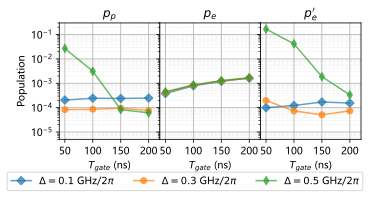

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

l = 0.15
w = 0.28
b = 0.3
t = 0.9
fig = plt.figure(figsize=(5, 2.7)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=l, right=l+w,bottom=b,top = t)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=l+w, right=l+w*2,bottom=b,top = t)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=l+w*2, right=l+w*3,bottom=b,top = t)

axs = [fig.add_subplot(gs0[0]),  fig.add_subplot(gs1[0]),  fig.add_subplot(gs2[0])]
markers = ['D','D','o','o','d']
for j,title,data_arr in zip([0,1,2],[r"$p_p$", r"$p_e$", r"$p_e'$"], [fidelity_arr,leak_to_e_arr, additional_leakage_arr]):
    ax = axs[j]
    for i in [0,2,4]:
        ax.plot(t_duration_arr, data_arr[i], label=rf"$\Delta={detuning_arr[i]}$ GHz/$2\pi$", marker=markers[i],alpha=0.7)
    ax.set_yscale('log')
    ax.set_xticks([50, 100, 150, 200])
    ax.set_xlim(40,220)
    ax.set_ylim(5e-6,3e-1)
    ax.set_xlabel(r"$T_{gate}$ (ns)")
    ax.set_title(title)

    # Major and minor ticks for logarithmic scale
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Set major ticks
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))  # Set minor ticks

    ax.grid(which='major', linestyle='-')  # Solid grid lines for major ticks
    ax.grid(which='minor', linestyle='--',alpha=0.2)  # Dashed grid lines for minor ticks
axs[0].set_ylabel('Population')
axs[1].set_ylabel('')
axs[1].set_yticklabels([])
axs[2].set_ylabel('')
axs[2].set_yticklabels([])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[:8], labels[:8], loc='lower center',ncol = 4, bbox_to_anchor=(0.5, 0.01))

fig.savefig('raman_comprehensive.pdf')